# Project 1: Regression and Model Selection

In this project, you will construct a linear regression model, and apply it to a synthetic task as well as a real-world house value prediction task.

## Objectives
Your goal in this project is to get comfortable in implementing a complete supervised learning pipeline (in Python). To complete this project, you should understand the following:

* How to use basic math and machine learning modules in python such as numpy, matplotlib, and sklearn (*_You are encouraged to use numpy to vectorize array operations [see link](https://numpy.org/doc/stable//user/absolute_beginners.html#basic-array-operations)_*)
* How to train a regression model *from scratch*
* How to implement the *gradient descent* algorithm for iterative model update
* How to perform model section when facing multiple choices
* How to evaluate the test results and visualize the outcome of an ML model

## Deliverable
* Project report/writeup: A `project1_report_lastname.pdf` file with corresponding plots and results for the project. Follow the `Project 1 - Report (Individual Submission)` link on Gradescope to upload this file. The project report should include a brief justification of your solution at a high-level, e.g., using any relevant explanations, equations, or pictures that help to explain your solution. You should also describe what your code does, e.g. using a couple of sentences per function to describe your code structure. 

* Source code: A `project1_src_lastname1[_lastname2].ipynb` (or `.zip`) file with a working copy of your solutions compiled in a Jupyter notebook. Follow the `Project 1 - Source Code (Group Submission)` link to upload this file.


## Logistics

* You can work in groups of 1-2 students for each course project, and it's your responsibility to find a group (e.g. use Ed Discussion). 
* Every member of a group must complete and submit the project report/writeup individually. While the source code can be the same for all group members, the project report needs to be written independently by each person and, thus, should differ among team member and students more generally.
* One one group member need to submit the source code. If you submit as a group, make sure to include your teammate in the group submission. Instructions for team submission can be found [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
* Grades will be provided based on the individual project report. The source code submission will not be graded, but the teaching staff may check the source files if they see the need for reproducing your results when going through your project report. 
* Failure to submit the source code will lead to a deduction of points from your total.


# Task 1A: Linear Regression (50 points + 10 bonus points)

## Overview
In this task, you will implement linear regression with gradient descent optimization from scratch. You'll work with a synthetic dataset to understand the core concepts of regression and optimization.

### Learning Objectives
- Implement linear regression without using pre-built ML libraries
- Understand gradient descent optimization
- Learn to visualize and analyze model performance
- Master loss function implementation and optimization

## Problem Setup

### Loading Necessary Dependencies

In [1]:
%matplotlib inline

# General math and plotting modules.
import numpy as np                                      # NumPy is a library for numerical operations on large, multi-dimensional arrays and matrices.
import matplotlib.pyplot as plt                         # Matplotlib is a plotting library for creating static, animated, and interactive visualizations in Python.
from matplotlib.colors import ListedColormap            # ListedColormap is used to create custom colormaps for plotting.

# Machine Learning library.
from sklearn.model_selection import train_test_split    # train_test_split is a utility function to split data into training and testing sets.
from sklearn.preprocessing import StandardScaler        # StandardScaler is used to standardize features by removing the mean and scaling to unit variance.

### Utility Functions

This section provides utility functions for data generation and visualization. These functions are pre-implemented to help you focus on the core machine learning concepts. You don't need to modify these functions.

#### Data Generation

In [2]:
from typing import Tuple

def generate_polynomial_data(num_points: int, noise: float, w: np.array) -> Tuple[np.array, np.array]:
    """
    Generate synthetic polynomial regression data.
    
    Args:
        num_points (int): Number of data points to generate
        noise (float): Standard deviation of Gaussian noise
        w (np.array): True polynomial coefficients [w_n, ..., w_1, w_0]
                     where n is the polynomial degree
    
    Returns:
        x1 (np.array): Feature matrix of shape (num_points, degree+1)
                      Each row is [x^n, ..., x^1, 1]
        y (np.array): Target values of shape (num_points,)
    """
    dim = w.size - 1  # Polynomial degree
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate base feature values from normal distribution
    x = np.random.normal(size=(num_points, 1))
    
    # Initialize with bias term (x^0 = 1)
    x1 = np.power(x, 0)
    
    # Build polynomial features up to specified degree
    for d in range(dim):
        # Concatenate new polynomial term to existing features
        # Final matrix: [x^n, ..., x^1, 1]
        x1 = np.concatenate((np.power(x, 1 + d), x1), axis=1)
    
    # Generate target values: y = Xw + noise
    y = np.dot(x1, w) + np.random.normal(size=(num_points,)) * noise

    return x1, y

#### Visualization Functions

In [3]:
def plot_data(X: np.array, Y: np.array, fig=None, options: dict = dict())->None:
    """
    Plot data points.
    
    Args:
        X (np.array): Feature values for x-axis
        Y (np.array): Values for y-axis
        fig: Matplotlib figure object (optional)
        options (dict): Plotting options including:
            - marker: Point style (default: 'b*')
            - label: Legend label (default: 'Raw data')
            - fillstyle: Point fill style (default: 'full')
            - size: Point size (default: 8)
    """
    if fig is None:
        fig = plt.subplot(111)
    
    # Plot data points with specified options
    fig.plot(X, Y, 
            options.get('marker', 'b*'),        # Default: blue stars 
            label=options.get('label', 'Raw data'),
            fillstyle=options.get('fillstyle', 'full'),
            ms=options.get('size', 8))
    
    process_plot(fig, options)

def plot_fit(X: np.array, w: np.array, fig=None, options: dict = dict())->None:
    """
    Plot the polynomial regression fit line.
    
    Args:
        X (np.array): Original feature matrix
        w (np.array): Learned polynomial coefficients
        fig: Matplotlib figure object (optional)
        options (dict): Plotting options
    """
    if fig is None:
        fig = plt.subplot(111)

    # Get range of x values to plot
    x_min = np.min(X[:, -2])
    x_max = np.max(X[:, -2])
    dim = w.size - 1  # Polynomial degree
    
    # Generate smooth x values for plotting
    x_plot = np.reshape(np.linspace(x_min, x_max, 100), [-1, 1])
    x1_plot = np.ones_like(x_plot)  # Initialize with ones (bias term)
    
    # Generate polynomial features for plotting
    for d in range(dim):
        x1_plot = np.concatenate((np.power(x_plot, 1 + d), x1_plot), axis=1)

    # Calculate predicted y values
    y_plot = np.dot(x1_plot, w)
    
    # Plot regression line
    fig.plot(x_plot, y_plot, 'r-', 
            label=options.get('label', 'Regression fit'))
    
    process_plot(fig, options)

def process_plot(fig, options: dict = dict())->None:
    """
    Apply common plotting options to figure.
    
    Args:
        fig: Matplotlib figure object
        options (dict): Dictionary of plotting options including:
            - x_label: Label for x-axis
            - y_label: Label for y-axis
            - x_lim: Limits for x-axis
            - y_lim: Limits for y-axis
            - title: Plot title
            - legend: Whether to show legend
            - legend_loc: Legend location
    """
    # Set axis labels
    if 'x_label' in options.keys():
        fig.set_xlabel(options['x_label'])
    if 'y_label' in options.keys():
        fig.set_ylabel(options['y_label'])
    
    # Set axis limits
    if 'x_lim' in options.keys():
        fig.set_ylim(options['x_lim'])
    if 'y_lim' in options.keys():
        fig.set_ylim(options['y_lim'])
    
    # Set title and legend
    if 'title' in options.keys():
        fig.set_title(options['title'])
    if 'legend' in options.keys():
        if options['legend']:
            fig.legend(loc=options.get('legend_loc', 'best'))

### Usage Example
Notes:
- The `generate_polynomial_data` function creates synthetic data following y = w₁x + w₀ + noise
- For reproducibility, we use a fixed random seed (42)
- The plotting functions support customization through the options dictionary
- These functions are designed to work with polynomial regression of any degree

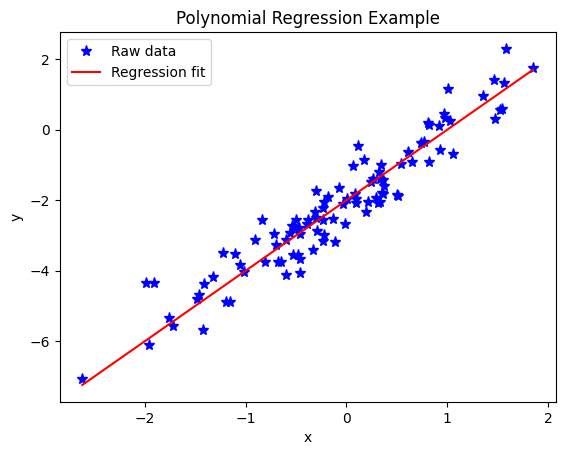

In [4]:
# Generate synthetic data
num_points = 100
noise = 0.6
w_true = np.array([2, -2])  # Linear function: y = 2x -2
X, y = generate_polynomial_data(num_points, noise, w_true)

# Create plot
fig = plt.subplot(111)
plot_options = {
    'x_label': 'x',
    'y_label': 'y',
    'title': 'Polynomial Regression Example',
    'legend': True
}

# Plot data and fit
plot_data(X[:, 0], y, fig=fig, options=plot_options)
plot_fit(X, w_true, fig=fig, options=plot_options)
plt.show()

### Loading and Processing Dataset 

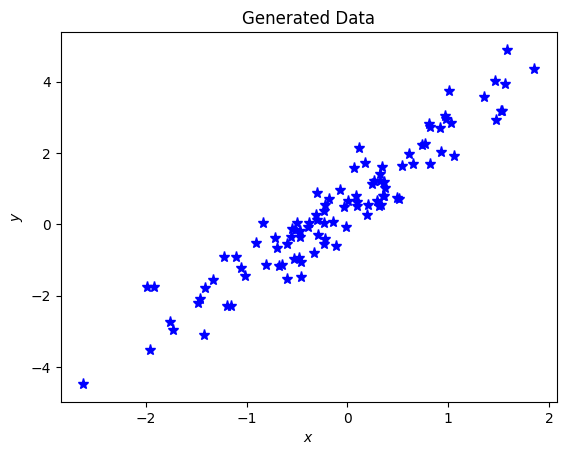

In [5]:
def generate_and_plot_data(num_points: int, noise: float, w_true: np.array, test_size: float = 0.4, random_state: int = 42) -> Tuple[np.array, np.array, np.array, np.array]:
    """
    Generate synthetic polynomial regression data, split into training and testing sets, and plot the data.
    
    Args:
        num_points (int): Number of data points to generate
        noise (float): Standard deviation of Gaussian noise
        w_true (np.array): True polynomial coefficients [w_n, ..., w_1, w_0]
        test_size (float): Proportion of the dataset to include in the test split
        random_state (int): Random seed for reproducibility
    
    Returns:
        X_train (np.array): Training feature matrix
        X_test (np.array): Testing feature matrix
        y_train (np.array): Training target values
        y_test (np.array): Testing target values
    """
    # Generate the data
    X, y = generate_polynomial_data(num_points, noise, w_true)  # y = X w_true + noise

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Plot Data
    fig = plt.subplot(111)
    plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(y) - 0.5, np.max(y) + 0.5]}
    plot_data(X[:, 0], y, fig=fig, options=plot_opts)
    
    return X_train, X_test, y_train, y_test

# Example usage
num_points = 100  # Number of training points
noise = 0.6  # Noise level
w_true = np.array([2, 0.6])  # Ground truth function parameter

X_train, X_test, y_train, y_test = generate_and_plot_data(num_points, noise, w_true)

## Task 1A.1: Modeling (30 pts)

In the following, you will write you own loss function for this linear regression task.

### The key ingredient of modeling: Risk (i.e. expected loss) function and its gradient

We will start by fitting by linear regression a set of data points of the type $\left\{(\mathbf{x}, y)_i\right\}$, $i \in \{1, 2, \ldots, n\}$.

The objective of linear regression, is to find coefficents $\hat{\mathbf{w}}$ such that the residual between $\hat{y} = \hat{\mathbf{w}}^\top \tilde{\mathbf{x}}$, and $y$ is small. (Remember that $\tilde{\mathbf{x}} = [\mathbf{x}, 1]$). From now on, $\mathbf{x}$ will be considered the extended version unless stated otherwise, hence dropping the tilde notation. 

We consider the ridge regression risk function, defined as 
$$ R({\mathbf{w}}) = \mathbb{E}[(y-{\mathbf{w}}^\top \mathbf{x})^2)] +  \lambda \mathbf{w}^\top \mathbf{w}$$

where the expectation is taken over the data generating the distribution of points. As the data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the *empirical risk* as:


$$\hat{R}_{\text{ridge}}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \mathbf{w}^\top \mathbf{x}_i\right)^2 + \lambda \mathbf{w}^\top \mathbf{w}$$

In the following, construct a customized funciton which returns the empirical risk and its gradient at parameter $\mathbf{w}$:

In [17]:
# Constructing the empirical risk function for ridge regression.
def lossFunction(w, X, y ,Lambda):
    """
    Take in numpy array of w, X, and y to return the regularize loss function and gradient
    of a logistic regression
    """
    # initialize regularized average loss (empirical risk) and its gradient
    regLoss = 0
    grad = np.zeros(w.shape)

    ##############################################################
    # add your code to compute the ridge regression risk function and its gradient #
    # ridge regression risk function
    n = X.shape[0]

    regLoss =  ((1 / n) * (np.sum((y - (X @ w))**2))) + (Lambda * (w.T @ w))

    # gradient
    grad = (-2 / n) * X.T @ (y - X @ w) + (2 * Lambda * w)
    
    ##############################################################

    return regLoss, grad

# Initialize fitting parameters
initial_w = np.zeros((X.shape[1], 1))

# Set regularization parameter lambda
Lambda = 0.01

# Compute and display initial loss and gradient for regularized logistic regression
emp_risk, grad=lossFunction(initial_w, X, y, Lambda)
print("Loss at initial w (zeros):",emp_risk)

Loss at initial w (zeros): [[812.44923075]]


## Task 1A.2: Training Your Ridge Regressor: Gradient Descent (15 pts)

There are many algorithmic tools for training your regressor. Here, we use the popular gradient descent algorithm.

The parameters $\hat{\mathbf{w}}$ can be updated via a gradient descent rule: 

$$ \hat{\mathbf{w}}_{t+1} \gets \hat{\mathbf{w}}_t - \eta_t \left.\frac{\partial \hat{R}}{\partial \mathbf{w}} \right|_{\mathbf{w}=\hat{\mathbf{w}}_t},$$

where $\eta_t$ is a parameter of the algorithm, $t$ is the iteration index, and $\frac{\partial \hat{R}}{\partial \mathbf{w}}$ is the gradient of the empirical risk function w.r.t. $\mathbf{w}$.

In the *vanilla* gradient descent method, $\eta_t=\eta_0$ is a constant. However other algorithms exists that modify this.

The computational complexity of gradient descent is $O(n_{\text{iter}} \cdot  n d)$. 


Write a customized function `gradientDescent(X,y,theta,eta,Lambda,tolerance)`
 which returns an array of empirical risk values, one for each iteration, as well as the final output of the model parameter. 
 
 Here, `tollerance` specifies the stopping condition: The gradient descent algorithm terminates the observed loss values converges (i.e. two consective losses differ by at most `tollerance`). 

 (*Hint: the loss should be descending in the loss plot.*)

The regularized w using ridge regression:
 [[ 3.16176077e-03 -1.94849074e-03 -2.57693421e-03  2.41150272e-03
  -1.16398138e-03  2.04055403e-03 -9.20411543e-04 -2.45784841e-03
   1.05570306e-03  2.01198156e-03  1.57232807e-04 -3.64134121e-03
  -6.06704895e-04  1.80446431e-03  2.12194594e-04 -7.18820298e-04
  -5.62666142e-03 -3.22526066e-03 -6.30277957e-04 -8.25711300e-04
  -4.72093110e-05  6.38540784e-04 -3.26526200e-03 -1.24925551e-04
  -1.60909218e-03 -4.30921320e-03  1.22361837e-03 -1.35316742e-03
  -8.06503265e-04 -1.39724334e-03  2.00556241e-03 -1.98713634e-03
  -6.30242921e-04 -1.84144476e-03 -7.42321238e-04 -3.05919560e-04
  -3.15281527e-03  7.40727215e-05  9.24032409e-05 -3.38858471e-03
   2.62894944e-03  1.32443163e-03  4.04162126e-03  3.28469172e-04
  -8.17904967e-05  1.33685131e-03  4.57006798e-04 -1.94424852e-03
   3.55609641e-03 -1.39662116e-03 -3.51067274e-03  5.14724483e-03
  -3.12362631e-03 -3.35202989e-03 -4.60926477e-03  1.08521042e-03
  -3.66653231e-03  3.41186143e-03

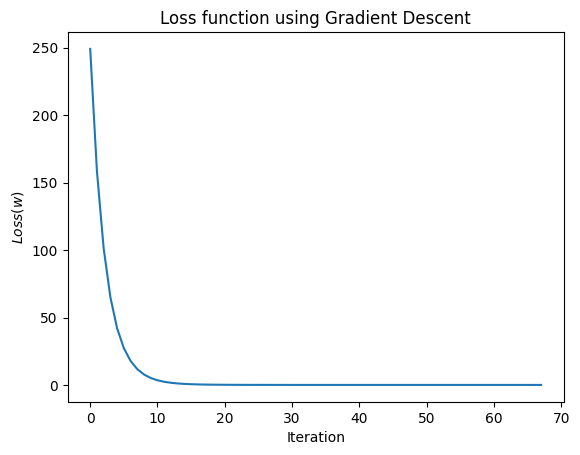

In [19]:
def gradientDescent(X: np.array, y: np.array, w: np.array, eta: float, Lambda: float, tolerance: float) -> Tuple[np.array, list]:
    """
    Perform gradient descent to minimize the loss function.
    
    Args:
        X (np.array): Feature matrix
        y (np.array): Target values
        w (np.array): Initial coefficients
        eta (float): Learning rate
        Lambda (float): Regularization parameter
        tolerance (float): Convergence tolerance
    
    Returns:
        Tuple[np.array, list]: Final coefficients and loss history
    """
    Loss_history = []
    m = len(y)
    prev_loss = np.inf
    
    ##############################################################
    # add your code to compute the output of the gradient, as well as the loss histroy #
    regLoss, grad = lossFunction(w, X, y, Lambda)
    Loss_history.append(regLoss[0][0])

    while abs(regLoss[0][0] - prev_loss) > tolerance:
        w = w - (eta * grad)

        prev_loss = regLoss[0][0]

        regLoss, grad = lossFunction(w, X, y, Lambda)
        Loss_history.append(regLoss[0][0])
    ##############################################################
    
    return w, Loss_history

# Parameters
Eta = 0.1
Tolerance = 1e-6


# Perform gradient descent
w, Loss_history = gradientDescent(X_train, y_train, initial_w, Eta, Lambda, Tolerance)
print("The regularized w using ridge regression:\n", w)

# Plot loss history
plt.plot(Loss_history)
plt.xlabel("Iteration")
plt.ylabel("$Loss(w)$")
plt.title("Loss function using Gradient Descent")
plt.show()

## Task 1A.3: Test Module (5 pts)

We still need a method to evaluate the model constructed. Here, we plot the predicted values on the test data, together with the training points.

You can plot the final results with the following script. Include the results in your project report and briefly (in 2~3 sentences) explain your observation.

NameError: name 'w' is not defined

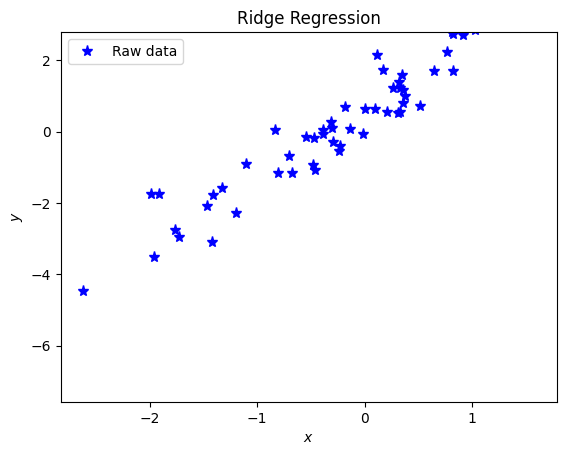

In [14]:
# Plot predicted function
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Ridge Regression', 'legend': True,
                 'y_lim': [np.min(y)-0.5, np.max(y)+0.5]}

plot_data(X_train[:,0], y_train, fig=fig, options=plot_opts)
plot_fit(X_test, w, fig=fig, options=plot_opts)


## [Bonus] Task 1A.4: True Risk (10 pts)

In this task, you will compute the expected error (true risk) of your model, and answer a few questions related to model selection based on your observations.


### 1A.4.1 Estimation of Expected Error for Linear Regressor (6 pts)

In this task, you will compute and compare the expected error and estimated error of your trained model.


**Direct Estimation (Students' Task):**

We first give a brief overview of the estimation of the model's expected error, and some factors related to the model consistency.

The true risk for our linear regression model can be directly computed since we know:
- Input $\mathbf{x} = [x_0, 1]^\top$ is sampled from standard normal distribution where $x_0 \sim \mathcal{N}(0,1)$
- True parameter is $\mathbf{w}_\text{true} = [2, -2]^T$
- Noise follows $\epsilon \sim \mathcal{N}(0, \sigma^2)$ where $\sigma = 0.6$

For a learned parameter $\hat{\mathbf{w}}$, the true error given MSE as the loss function is:

\begin{align}
E(\hat{\mathbf{w}}) &= \mathbb{E}_\mathbf{x}[(\mathbf{w}_\text{true}^\top \mathbf{x} + \epsilon - \hat{\mathbf{w}}^\top \mathbf{x})^2] \\

&= \mathbb{E}_\mathbf{x}[(\mathbf{w}_\text{true}^\top \mathbf{x} - \hat{\mathbf{w}}^\top \mathbf{x})^2] + \mathbb{E}[\epsilon^2] \\

&= (\mathbf{w}_\text{true} - \hat{\mathbf{w}})^\top \mathbb{E}[\mathbf{x}\mathbf{x}^\top](\mathbf{w}_\text{true} - \hat{\mathbf{w}}) + \sigma^2 \\

&= (\mathbf{w}_\text{true} - \hat{\mathbf{w}})^\top I(\mathbf{w}_\text{true} - \hat{\mathbf{w}}) + \sigma^2 \\

&= \|\mathbf{w}_\text{true} - \hat{\mathbf{w}}\|_2^2 + \sigma^2

\end{align}


where we used:
- $\mathbb{E}[\mathbf{x}\mathbf{x}^T] = I$ (for $x_0 \sim \mathcal{N}(0,1)$)
- $\mathbb{E}[\epsilon^2] = \sigma^2$
- Independence of $\mathbf{x}$ and $\epsilon$

**K-fold Cross-validation:**

We can compare this theoretical expected error with estimates from $k$-fold cross-validation:

$$\hat{E}(\hat{\mathbf{w}}) = \frac{1}{k} \sum_{i=1}^k \left[ \frac{1}{|V_i|} \sum_{(\mathbf{x},y)\in V_i} (y - \hat{\mathbf{w}}_i^\top \mathbf{x})^2 \right]$$

where
- $k$ is the number of folds
- $V_i$ is the validation set ($i$-th fold)
- $\hat{\mathbf{w}}_i$ is the model trained on all folds except $V_i$
- $|V_i|$ is the size of the validation fold

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Students Code for this function
def true_gen_error(w: np.array, w_true: np.array = np.array([2, 0.6]), sigma: float = 0.6) -> float:
    """
    Calculate true expected error.
    
    Args:
        w (np.array): Learned polynomial coefficients
        w_true (np.array): True polynomial coefficients
        sigma (float): Standard deviation of Gaussian noise
    
    Returns:
        float: True risk
    """
    error = 0
    ##############################################################
    # please add your code here to compute the expected error (true risk)
    #
    #


    ##############################################################
    
    return error

# In this section we directly call CV from sklearn
def estimate_gen_error_cv(X: np.array, y: np.array, k: int = 5) -> Tuple[float, float]:
    """
    Estimate expected error using k-fold cross-validation.
    
    Args:
        X (np.array): Feature matrix
        y (np.array): Target values
        k (int): Number of folds for cross-validation
    
    Returns:
        Tuple[float, float]: Mean and standard deviation of the estimated expected error
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    errors = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train model
        initial_w = np.zeros((X_train.shape[1], 1))
        w, _ = gradientDescent(X_train, y_train, initial_w, 0.01, 0.1, 1e-6)
        
        # Calculate MSE on validation set
        y_pred = X_val.dot(w)
        mse = mean_squared_error(y_val, y_pred)
        errors.append(mse)
    
    return np.mean(errors), np.std(errors)

# Compare theoretical and estimated errors
w_learned, _ = gradientDescent(X_train, y_train, np.zeros((2, 1)), 0.01, 0.1, 1e-6)
true_error = true_gen_error(w_learned)
cv_error, cv_std = estimate_gen_error_cv(X_train, y_train)

print(f"True expected error: {true_error:.4f}")
print(f"5-fold CV estimate: {cv_error:.4f} (±{cv_std:.4f})")

### 1A.4.2 Convergence of Expected Error (4 pts)

As discussed by Vladimir Vapnik in his foundation laying work *The Nature of Statistical Learning Theory* (Springer, 1995), learning theory must address four principal questions:

1. *What are the (necessary and sufficient) conditions for consistency of a learning process based on the Empirical Risk Minimization (ERM) principle?*  
2. ***How fast is the rate of convergence of the learning process?***
3. *How can one control the rate of convergence (the generalization ability) of the learning process?*  
4. *How can one construct algorithms that can control the generalization ability?*

When we focus on the second question—namely, the rate of convergence of the learning process—and how various factors affect the **expected error**. Key considerations include:

- **Distribution mismatch**: Differences between the training data generation distribution and the “true” (or test) distribution, often quantified through divergences such as KL divergence.  
- **Number of training samples**: Larger datasets typically lead to faster convergence rates under mild assumptions about the data-generating process.  
- **Model complexity**: More complex hypothesis classes may require stronger regularization or more data to achieve comparable convergence.  
- **Observation noise**: Higher noise levels can slow convergence by obscuring the true signal and increasing variance in parameter estimates.

In what follows, we briefly highlight the role of observation noise in shaping the convergence rate of the expected error in empirical study. We will see that increasing noise typically inflates error bounds and slows down the overall convergence, further underscoring the importance of careful model selection and noise-robust learning algorithms.

**Your task is to implement the naive linear regression in the corresponding part, and answer the following questions.**

In [ ]:
def analyze_noise_impact(noise_levels: list = [0.9, 1.2, 1.5, 1.8, 2.1, 2.4], 
                         sample_sizes: np.array = np.linspace(10, 30, 6, dtype=int),
                         w_true: np.array = np.array([2, 0.6]),
                         n_repeats: int = 10) -> None:
    """
    Analyze impact of observation noise on expected error convergence.
    
    Args:
        noise_levels (list): Different noise levels to test
        sample_sizes (np.array): Different sample sizes to test
        w_true (np.array): True polynomial coefficients
        n_repeats (int): Number of repetitions for each configuration
    """
    # Store results
    true_errors = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    cv_errors = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    cv_stds = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}

    # Store results for naive linear regression
    naive_true_errors = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    naive_cv_errors = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    naive_cv_stds = {noise: np.zeros((len(sample_sizes), n_repeats)) for noise in noise_levels}
    
    def fit_naive_linear_regression(X: np.array, y: np.array) -> np.array:
        """Fit linear regression using normal equations"""
        w = np.zeros((X.shape[1], 1))
        ##############################################################
        # please add your code here to fit the linear regression without regularization
        # the answer should return the learned weight vector given training data X and y
        #
        #
        
        
        ##############################################################
        
        return w
    
    def estimate_naive_gen_error_cv(X: np.array, y: np.array, k: int = 5) -> Tuple[float, float]:
        """Estimate expected error for naive linear regression using k-fold CV"""
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        errors = []
        
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            w = fit_naive_linear_regression(X_train, y_train)
            y_pred = X_val @ w
            mse = mean_squared_error(y_val, y_pred)
            errors.append(mse)
        
        return np.mean(errors), np.std(errors)
    
    # Run experiments
    for noise in noise_levels:
        print(f"Processing noise level: {noise}")
        for i, n_samples in enumerate(sample_sizes):
            for j in range(n_repeats):
                # Generate data
                X_train, X_test, y_train, y_test = generate_and_plot_data(
                    n_samples, noise, w_true, test_size=0.2)
                
                # Train model
                w_init = np.zeros((X_train.shape[1], 1))
                w_learned, _ = gradientDescent(X_train, y_train, w_init, 0.001, 0.1, 1e-6)
                
                # Calculate true expected error
                true_errors[noise][i, j] = true_gen_error(w_learned, w_true, noise)
                
                # Estimate expected error using cross-validation
                cv_error, cv_std = estimate_gen_error_cv(X_train, y_train)
                cv_errors[noise][i, j] = cv_error
                cv_stds[noise][i, j] = cv_std

                # Naive linear regression
                w_naive = fit_naive_linear_regression(X_train, y_train)
                naive_true_errors[noise][i, j] = true_gen_error(w_naive, w_true, noise)
                naive_cv_error, naive_cv_std = estimate_naive_gen_error_cv(X_train, y_train)
                naive_cv_errors[noise][i, j] = naive_cv_error
                naive_cv_stds[noise][i, j] = naive_cv_std
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot true expected error for ridge regression
    plt.subplot(231)
    for noise in noise_levels:
        mean_error = np.mean(true_errors[noise], axis=1)
        std_error = np.std(true_errors[noise], axis=1)
        
        plt.plot(sample_sizes, mean_error, label=f'σ={noise}', marker='o')
        plt.fill_between(sample_sizes, mean_error - std_error, mean_error + std_error, alpha=0.2)
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel('True Expected Error')
    plt.title('Ridge Regression: True Expected Error')
    plt.legend()
    plt.grid(True)
    
    # Plot CV estimated error for ridge regression
    plt.subplot(232)
    for noise in noise_levels:
        mean_error = np.mean(cv_errors[noise], axis=1)
        mean_std = np.mean(cv_stds[noise], axis=1)
        
        plt.plot(sample_sizes, mean_error, label=f'σ={noise}', marker='o')
        plt.fill_between(sample_sizes, mean_error - mean_std, mean_error + mean_std, alpha=0.2)
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel('CV Estimated Error')
    plt.title('Ridge Regression: CV Est. Error')
    plt.legend()
    plt.grid(True)

    # Plot ratio of true/CV error for ridge regression
    plt.subplot(233)
    for noise in noise_levels:
        mean_true = np.mean(true_errors[noise], axis=1)
        mean_cv = np.mean(cv_errors[noise], axis=1)
        ratio = mean_true / mean_cv
        
        plt.plot(sample_sizes, ratio, label=f'σ={noise}', marker='o')
    
    plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Number of Training Samples')
    plt.ylabel('True/CV Error Ratio')
    plt.title('Ridge Regression: Error Ratio')
    plt.legend()
    plt.grid(True)

    # Plot true expected error for naive regression
    plt.subplot(234)
    for noise in noise_levels:
        mean_error = np.mean(naive_true_errors[noise], axis=1)
        std_error = np.std(naive_true_errors[noise], axis=1)
        
        plt.plot(sample_sizes, mean_error, label=f'σ={noise}', marker='o')
        plt.fill_between(sample_sizes, mean_error - std_error, mean_error + std_error, alpha=0.2)
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel('True Expected Error')
    plt.title('Naive Regression: True Expected Error')
    plt.legend()
    plt.grid(True)

    # Plot CV estimated error for naive regression
    plt.subplot(235)
    for noise in noise_levels:
        mean_error = np.mean(naive_cv_errors[noise], axis=1)
        mean_std = np.mean(naive_cv_stds[noise], axis=1)
        
        plt.plot(sample_sizes, mean_error, label=f'σ={noise}', marker='o')
        plt.fill_between(sample_sizes, mean_error - mean_std, mean_error + mean_std, alpha=0.2)
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel('CV Estimated Error')
    plt.title('Naive Regression: CV Est. Error')
    plt.legend()
    plt.grid(True)
    
    # Plot ratio of true/CV error for naive regression
    plt.subplot(236)
    for noise in noise_levels:
        mean_true = np.mean(naive_true_errors[noise], axis=1)
        mean_cv = np.mean(naive_cv_errors[noise], axis=1)
        ratio = mean_true / mean_cv
        
        plt.plot(sample_sizes, ratio, label=f'σ={noise}', marker='o')
    
    plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Number of Training Samples')
    plt.ylabel('True/CV Error Ratio')
    plt.title('Naive Regression: Error Ratio')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_noise_impact()

#### Questions
Please discuss your findings by addressing the following questions.

- How does observation noise affect generalization performance?
- Under what conditions is ridge regression meaningful, and when does naïve linear regression lead to overfitting?

# Task 1B: Model Selection for House Value Prediction (50 points)

We will use the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from the scikit-learn package. The task is to predict the house values in California districts given some summary stats about them based on the 1990 census data.

The dataset has 8 features: longitudes, latitudes, housing median age, total rooms, total bedrooms, population, households, median income, and median house value. The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($\$100,000$). We split the dataset as 80\% for training data and 20\% for testing data. 

The following script loads the dataset (using pandas dataframe):

In [ ]:
# python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import pandas as pd

california=fetch_california_housing()
california_df=pd.DataFrame(california.data,columns=california.feature_names)
california_df['Price']=california.target
california_df 

newX=california_df.drop('Price',axis=1)
newY=california_df['Price']

newX = StandardScaler().fit_transform(newX)

## Task 1B.1: Ridge Regression (30 pts)


Following the script below, you will be able to generate the training and test data.

In [ ]:
N_train = len(newX) * .8

np.random.seed(150)
msk = np.random.rand(len(newX)) < 0.8

X_train, y_train = newX[msk], newY[msk]
X_test, y_test = newX[~msk], newY[~msk]

### Training and evaluation (15 pts)

Write a function to fit the Ridge regression model on the training data and calculate the MSE on the test set. Choosing $\lambda$ from $\{10^{-10}, 10^{-6}, 10^{-4}, 10^{-2}, 10^{-1}, 1, 10, 20, 50, 100\}$, compute the estimate $\hat{\mathbf{y}}$ for different values $\lambda$, and plot the test MSE as a function of $\lambda$. 


❗**Note**: You should use your own model fitting and prediction (following the ones you construct in Task 1A). You may call your customized function `lossFunction` and `gradientDescent` from Task 1A.1 and 1A.2. Do not use `sklearn.linear_model` module (i.e. for model fitting and making predictions).

In [ ]:
def train_and_eval( X_train , y_train , X_eval , y_eval , lambda_ ):
  
    mse = 0
    # Initialize weight
    initial_w = np.zeros((X_train.shape[1], 1))

    ##############################################################
    # add your code to train your model on X_train and evalute (i.e. computing MSE) on X_eval. 
    # For gradientDescent, you may try the following configuration for comparison with later sections
    #   Eta = 0.01, Tolerance = 1e-4, max_iter=1e4
    # but feel free to experiment.
    #
    
    
    # Make predictions on the evaluation set
    #
    ##############################################################
    
    return mse


weight_list = [1e-10, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 20, 50, 100]
result_list = []

# compute test MSE
for weight in weight_list:
    test_mse = train_and_eval ( X_train , y_train.values , X_test , y_test.values , weight )
    result_list.append ([ test_mse , weight ])
    result_array = np.array ( result_list )
print(result_array)
plt.figure()
plt.plot( result_array [: , -1] , result_array [: ,0] , label = 'test mse')
plt.xlabel('lambda')
plt.ylabel('test mse')
plt.yscale('log')
plt.legend()
plt.show()

#### Questions
- Suppose you found above that the optimal $\lambda$ was very close to 0. Does this necessarily mean that Ridge regression is not helpful for this dataset?

### Model Selection via k-fold Cross Validation (15 pts)

Implement *10-fold cross validation* on the training set to select $\lambda$. 

❗**Note:** For this subproblem, you should write your own function for cross validation; in particular, you should **not** call the existing `sklearn.model_selection` module.

In [ ]:
def cross_validation(X_train, y_train, lambda_, k=10):
    """
    Perform k-fold cross validation on X_train and y_train, return the mean square error on the test portion of (X_train,y_train) across the k folds
    """
    mse_list = []
    
    ##############################################################
    # add your code to perform k-fold cross validation
    #
    #
    #
    #
    
    return np.mean(mse_list)


# List of lambdas to try
weight_list = [1e-10, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 20, 50, 100]

best_lambda = None
best_mse = np.inf

# Find the best lambda
mse_list = []
for lambda_ in weight_list:
    print("cross validation with lambda: ", lambda_)
    
    ##############################################################
    # mse on the hold-out set
    cv_mse = cross_validation(X_train, y_train.values, lambda_)
    mse_list.append(cv_mse)
    if cv_mse < best_mse:
        best_mse = cv_mse
        best_lambda = lambda_

print("Best lambda: ", best_lambda)

Plot and compare the **(average) cross validation MSE** on the hold-out folds (i.e., test portion in each of the $k$ folds) with the **test MSE** which is computed on the test set (X_test, y_test). And see how we get to finding the ``best'' $\lambda$.


#### Questions
- Compare the model selection strategy used in vanilla ridge regression (i.e., on a single train/test split) and in $k$-fold cross validation. What are the pros and cons of each approach.
- Suppose the best $\lambda$ chosen by 10-fold cross-validation is significantly different from the best $\lambda$ you found using vanilla Ridge Regression. Which value would you trust more, and why? What are some potential reasons for this discrepancy?

## Task 1B.2: Polynomial Model Selection (20 pts)

In this question, you will perform polynomial regression on the California housing dataset, and use cross-validation to determine the optimal degree of polynomial. For simplicity, we will use **a subset of the longitudes feature** and study its relationship with housing prices. 


Following the previous notation, we consider the mean square risk function, defined as $$ R({\mathbf{w}}) = \mathbb{E}[(y-{\mathbf{w}}^\top \mathbf{x})^2)].$$ For a polynomial regression of degree $D$, this becomes $$ R({\mathbf{w}}) = \mathbb{E}[(y-\sum_{d = 1}^{D}w_d x^d)^2)] = \mathbb{E}[(y-{\mathbf{w}}^\top \mathbf{x})^2],$$ where the expectations are taken over the data generating the distribution of points. As the whole data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the *empirical risk* as: $$\hat{R}_{\text{MSE}}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \sum_{d = 1}^{D}w_d x_i^d\right)^2.$$

In the following, you will use gradient descent to find the the optimal $\mathbf{w}$ for a given $D$ based on the MSE loss, and implement a cross validation function that performs $10$-fold cross validation to determine the optimal $D$ to fit this set of data.

Following the script below, you will be able to generate the training data. 


In [ ]:
# load data
i= 45
num_data = 200
X_train = newX[i*num_data:(i+1)*num_data, 0]
y_train = np.array(newY[i*num_data:(i+1)*num_data])

You may create your customized function `lossFunctionMSE` and `gradientDescentMSE` by modifying the corresponding functions from the previous tasks to adapt to the MSE loss and its gradient. You also need to adapt your `cross_validation` function below to handle the varying degrees $D$. A sample plotting command has been provided. You should create other plots as you deem necessary.

In [ ]:
# Constructing the empirical risk function for MSE regression.
def lossFunctionMSE(w, X, y):
    """
    Take in numpy array of theta, X, and y to return the regularize loss function and gradient
    of the mean square error function
    """
    
    # initialize mse loss and its gradient
    loss = 0
    grad = np.zeros(w.shape)

    ##############################################################
    # add your code to compute the MSE risk function and its gradient
    #
    #
    
    ##############################################################
    
    return loss, grad


def gradientDescentMSE(X,y,w,eta,tolerance,max_iter=1000):
    """
    Take in numpy array X, y and w and update w by taking num_iters gradient steps
    with learning rate of eta
    
    return w and the list of the loss of w during each iteration
    """
    ##############################################################
    # add your code to perform gradient updates
    #
    #
    
    ##############################################################
    
    
    return w, Loss_history


def train_and_eval_dim( X_train , y_train , X_eval , y_eval , dim):
  
    mse = 0
    # Initialize weight
    initial_w = np.zeros((X_train.shape[1], 1))

    ##############################################################
    # add your code to train your model on X_train and evalute (i.e. computing MSE) on X_eval
    # Train the model
    #
    
    # Make predictions on the evaluation set
    #
    
    
    ##############################################################
    
    return mse

def cross_validation_dim(X_train, y_train, dim, k=10):
    """
    Perform k-fold cross validation on X_train and y_train
    
    return the mean square error on the test portion across the k folds
    """
    
    ##############################################################
    # add your code to perform k-fold cross validation on the degree parameter dim
    #
    #
    #
    
    ##############################################################
    
    return np.mean(mse_list)


# List of candidate degrees 
degree_list = np.linspace(0, 4, 5, dtype=int)

# Find the best degree
result_list = []
for degree in degree_list:
    print(degree)
    cv_mse = cross_validation_dim(X_train, y_train, degree)
    result_list.append ([ cv_mse , degree ])
result_array = np.array ( result_list )

plt.figure()
plt.plot( result_array [: , -1] , result_array [: ,0] , label = 'CV mse')
plt.xlabel('degree of polynomial')
plt.ylabel('mse')
plt.legend()
plt.show()


#### Questions
- How would you use this information to determine the degree of polynomial you will use to represent this dataset?
- Plot and analyze how the increasing degree of the polynomial change the training and validation loss. Do they change in different ways?